
# Mini Project 01 : Analysis of Residential Property in the Korean Urban Area

Dongjin Lee

Part 01: Data Collection

Coding Note : 
Due to origin of the data source, many of the coding was consist of Korean.
The translation of analysis was done after all the work is completed.







In [4]:
"""
Created on Mon Apr 11 18:30:05 2016
"""
# import packages 
import pandas as pd                   # data management
import matplotlib.pyplot as plt       # graphics 
import matplotlib as mpl              # graphics parameters
import numpy as np                    # numerical calculations 


# Checking Python version 
import datetime as dt 
import sys
print('Today is', dt.date.today())
print('What version of Python are we running? \n', sys.version, sep='') 

Today is 2016-04-20
What version of Python are we running? 
3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]


### Sources : Use the link to see the origin of the source
 
#### 01. Data location & Web Crawled Data (데이타 위치 및 가져온 곳)

    01-01. Korean Apartment(Residential Property) Management Info System
    http://www.k-apt.go.kr
    
    01-02. Ministry of Land and Infrastructure and Transportation (Korea)
    http://rt.molit.go.kr

#### 02. Study Material Location (Codes and Idiom)

    02-01. Basic Foundation of Python : http://databootcamp.nyuecon.com/
    02-02. Web Crawling method : https://www.coursera.org/learn/python-network-data/
    02-03. Sqlite3 http://www.tutorialspoint.com/sqlite/sqlite_python.htm

In [2]:
#%%
from matplotlib import cm, colors, _cm

# Data Collection
import urllib
import json
from time import time
import sqlite3

In [5]:
con = sqlite3.connect("C:\\Users\\Dongjin\\Desktop\\MV_02_realestate.db")
# sqlite3.connect
# connect(database[, timeout, detect_types, isolation_level,check_same_thread, factory, cached_statements, uri])
# Opens a connection to the SQLite database file *database*.

#  (City Code inserted in the DB by hand as follows)
state_info=pd.read_sql("select * from addr_si_code_tbl;",con)
state_info.head(10)

,si_code,name,update_tm
0,11,서울특별시,1460401951
1,26,부산광역시,1460401951
2,27,대구광역시,1460401951
3,28,인천광역시,1460401951
4,29,광주광역시,1460401951
5,30,대전광역시,1460401951
6,31,울산광역시,1460401951
7,36,세종특별자치시,1460401951
8,41,경기도,1460401951
9,42,강원도,1460401951


In [26]:
# Select 
# si, gun, gu data collection 
def Address_Info( code, type='SGG'  ):
    response = urllib.request.urlopen("http://www.k-apt.go.kr/cmmn/bjd/getBjdList.do?bjd_code=%d&bjd_gbn=%s" %(code,type) )
    data = json.loads(response.read().decode('utf-8'))
    return pd.DataFrame(data[u'resultList'])


In [27]:
# Get apartment information 
# http://www.k-apt.go.kr/kaptinfo/getKaptList.do?bjd_code=11350105
def getAptInfo(code):
    response = urllib.request.urlopen("http://www.k-apt.go.kr/kaptinfo/getKaptList.do?bjd_code=%d" % (code) )
    data = json.loads(response.read().decode('utf-8'))
    return pd.DataFrame(data[u'resultList'])


In [39]:
# crewling the 시, 군, 구 information
for name, code in state_info[['name','si_code']].itertuples(index=False):
    gu_info = Address_Info(code)
    values=gu_info.apply(lambda x : u"(%d, %s, '%s')" % (code, x['CODE'], x['CODE_VALUE'] ), axis=1)
    insert_sql = u"insert into addr_gu_code_tbl( si_code, gu_code, name) values %s ;" % (u",".join(values))
    con.execute(insert_sql)
    con.commit()
city_info=pd.read_sql("select * from addr_gu_code_tbl;",con)
city_info.head()


,si_code,gu_code,name
0,11,680,강남구
1,11,740,강동구
2,11,305,강북구
3,11,500,강서구
4,11,620,관악구


In [ ]:

# crewling the 읍, 면, 동 information
for si,gu in city_info[['si_code','gu_code']].itertuples(index=False):
    code = "%d%d" % (si,gu)
    info = Address_Info(int(code),'EMD')
    values=info.apply(lambda x : u"(%d, %d, %s, '%s')" % (si,gu, x['CODE'], x['CODE_VALUE'] ), axis=1)
    insert_sql = u"insert into addr_dong_code_tbl( si_code, gu_code, dong_code,name) values %s ;" % (u",".join(values))
    con.execute(insert_sql)
    con.commit()
    print ("%s code inserted(%d)" % (code, info.count()[0]))

In [41]:
# Collection of the "Dong-Code"
town_info=pd.read_sql("select * from addr_dong_code_tbl;",con)
print (town_info.head())


   si_code  gu_code  dong_code name
0       11      680        103  개포동
1       11      680        108  논현동
2       11      680        106  대치동
3       11      680        118  도곡동
4       11      680        105  삼성동


In [30]:
# http://www.k-apt.go.kr/kaptinfo/getKaptList.do?bjd_code=11350105
def getAptDetailInfo(code):
    response = urllib.request.urlopen("http://www.k-apt.go.kr/kaptinfo/getKaptInfo_detail.do?kapt_code=%s" % (code) )
    data = json.loads(response.read().decode('utf-8'))
    return data


In [31]:
def extractAptInfo(a):
    info = []
    for name in ['KAPT_CODE', 'KAPT_DONG_CNT','KAPT_USEDATE', 'KAPTD_WTIMESUB', 'SUBWAY_STATION', 'SUBWAY_LINE', 'CODE_HALL', 'KAPT_BCOMPANY' ] :
        info.append(a[u'resultMap_kapt'][name]);
    cnt = 0
    for x in a[u'resultMap_kapt_areacnt']:
        if( type(x[u'KAPTDA_CNT']) is int ):
            info.append(x[u'KAPTDA_CNT'])
        else :
            info.append(0)
#           cnt = cnt + x[u'KAPTDA_CNT']
 #   info.append(cnt)
    return info

In [ ]:
#%%
# crewling kapt code 정보
for code in town_info.apply(lambda x : x['si_code']*1000000+x['gu_code']*1000+x['dong_code'], axis=1):
    print ("%d code insert start"% (code))
    apt = getAptInfo(code)
    if apt.empty :
        continue
    apt.to_sql('apt_code_tbl2', con, index=False, if_exists='append' )

In [32]:
# Aparment를 수집했다.
apt_info=pd.read_sql("select * from apt_code_tbl2;",con)
apt_info.head()

,BJD_CODE,ENERGY_B_COUNT,KAPT_CODE,KAPT_NAME
0,1168010300,0,A13593901,LG개포자이아파트
1,1168010300,0,A13593908,SH공사대치1단지
2,1168010300,0,A13524006,개포2차 현대아파트
3,1168010300,0,A13580602,개포경남아파트
4,1168010300,0,A13524009,개포대치2단지


In [ ]:
#%%
# crewling apt detail 정보( 세대수, 건립년도, 인근 지하철 등 ) 
apt_details = pd.DataFrame(columns=['KAPT_CODE', 'KAPT_DONG_CNT','KAPT_USEDATE', 'KAPTD_WTIMESUB', 'SUBWAY_STATION', 'SUBWAY_LINE', 'CODE_HALL','KAPT_BCOMPANY', 'KAPTDA_CNT1', 'KAPTDA_CNT2', 'KAPTDA_CNT3', 'KAPTDA_CNT4'])

for code in apt_info['KAPT_CODE']:
    a = getAptDetailInfo(code)
    if not bool(a):
        continue
    info = extractAptInfo(a)
    if not bool(info):
        continue
    n=len(apt_details)
    apt_details.loc[n] = info
    print ("%s apt data collection completed(%d)" % (code,n)

In [ ]:
apt_details = pd.DataFrame(columns=['KAPT_CODE', 'KAPT_DONG_CNT','KAPT_USEDATE', 'KAPTD_WTIMESUB', 'SUBWAY_STATION', 'SUBWAY_LINE', 'CODE_HALL','KAPT_BCOMPANY', 'KAPTDA_CNT1', 'KAPTDA_CNT2', 'KAPTDA_CNT3', 'KAPTDA_CNT4'])

for code in apt_info['KAPT_CODE']:
    a = getAptDetailInfo(code)
    if not bool(a):
        continue
    info = extractAptInfo(a)
    if not bool(info):
        continue
    n=len(apt_details)
    apt_details.loc[n] = info

In [40]:
apt_details.head

<bound method NDFrame.head of    KAPT_CODE KAPT_DONG_CNT KAPT_USEDATE KAPTD_WTIMESUB SUBWAY_STATION  \
0  A13593901             4   2004-06-17        5~10분이내             대청   
1  A13593908             8   1991-11-20           5분이내            대모산   
2  A13524006            13   1986-01-31       10~15분이내             매봉   
3  A13580602             9   1984-11-01        5~10분이내             구룡   
4  A13524009            11   1992-10-20              -              -   

  SUBWAY_LINE CODE_HALL  KAPT_BCOMPANY  KAPTDA_CNT1  KAPTDA_CNT2  KAPTDA_CNT3  \
0         3호선       계단식           화엄건설          0.0          0.0          0.0   
1         중앙선       복도식           SH공사       1623.0          0.0          0.0   
2         3호선       계단식      현대산업개발(주)          0.0          0.0        112.0   
3    3호선, 분당선       계단식           경남건설          0.0          0.0        198.0   
4         3호선       복도식  성원건설.진덕산업주식회사       1176.0        577.0          0.0   

   KAPTDA_CNT4  
0        212.0  
1         

In [ ]:
def readAptData( dongcode, danjicode, year, quarter ) :
    url = "http://rt.molit.go.kr/rtApt.do?cmd=getTradeAptLocal&dongCode=%d&danjiCode=ALL&srhYear=%d&srhPeriod=%d&gubunRadio2=1" % ( dongcode, year, quarter )
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    apt_meta = pd.DataFrame(data['danjiList'])
    apt_data = pd.DataFrame(data['detailList'])
    return apt_meta, apt_data


In [29]:
apt_data=pd.read_sql("""
select si||" "||gu sigu, si, gu, dong, name, kcode, cast( KAPTDA_CNT as int ) KAPTDA_CNT, cast( KAPT_USEDATE as date ) KAPT_USEDATE
from apt_addr_tbl X, apt_info_tbl Y
where X.kcode=Y.kapt_code;
""",con)

In [32]:
apt_data.head()

,sigu,si,gu,dong,name,kcode,KAPTDA_CNT,KAPT_USEDATE
0,경기도 화성시,경기도,화성시,동탄면,동탄2 모아미래도,A10028158,460,2015
1,전라북도 부안군,전라북도,부안군,부안읍,부안봉덕3지구LH4차아파트,A10028160,554,2015
2,부산광역시 수영구,부산광역시,수영구,민락동,경동센텀메르빌,A10028161,157,2014
3,충청남도 예산군,충청남도,예산군,예산읍,예산 아뜨리움 아파트,A10028162,174,2015
4,경기도 화성시,경기도,화성시,반월동,신동탄 SK뷰 아파트,A10028164,238,2015


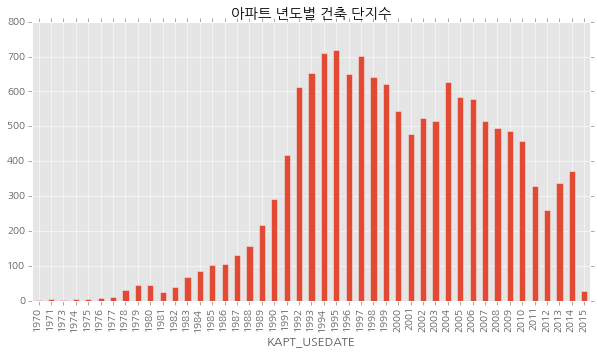

In [88]:
grouped = apt_data[(apt_data['KAPT_USEDATE']>0)].groupby(['KAPT_USEDATE'])
grouped.count()['KAPTDA_CNT'].plot(kind='bar',figsize=(10,5), title='아파트 년도별 건축 단지수')
plt.show()

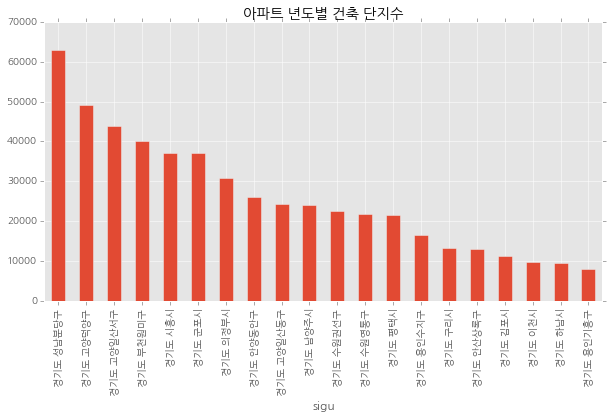

In [117]:
grouped = apt_data[((apt_data['KAPT_USEDATE']>=1993) & (apt_data['KAPT_USEDATE']<=1998) & (apt_data['si']=='경기도') )].groupby(['sigu'])
plan1=grouped.sum().sort(['KAPTDA_CNT'],ascending=False)['KAPTDA_CNT'].head(20)

plan1.plot(kind='bar',figsize=(10,5), title='아파트 년도별 건축 단지수')
plt.show()

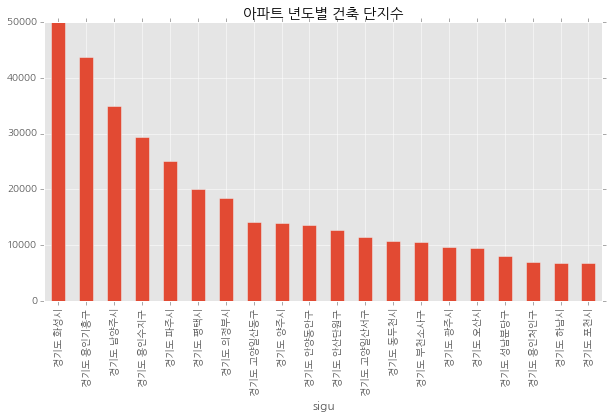

In [116]:
grouped = apt_data[((apt_data['KAPT_USEDATE']>=2003) & (apt_data['KAPT_USEDATE']<=2007) & (apt_data['si']=='경기도') )].groupby(['sigu'])
plan1=grouped.sum().sort(['KAPTDA_CNT'],ascending=False)['KAPTDA_CNT'].head(20)

plan1.plot(kind='bar',figsize=(10,5), title='아파트 년도별 건축 단지수')
plt.show()


All Right reserved. Source,Data, Coding Method to orginal locaiton of link mentioned above.

상기 모든 자료와 코드 작성법은 본 문서의 가장 위에 적힌 작성자 및 기관에게 권한이 있습니다.